# Modelo estatístico de previsão de chuva

**Sala: 2A**

**Grupo:**
> Breno Marti

> Diogo Cintra

> João Pedro Chacon Ruiz

> Luiz Felipe Valente

___
## • Imports

Importando as devidas funções para que se possa fazer a análise e filtragem dos dados, bem como a implementação do modelo de regrassão multipla.

In [2]:
#Importando as bibliotecas
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange
from numpy import percentile
import numpy as np
from pandas import DataFrame
from scipy.stats import probplot
import statsmodels.api as sm

## • Início da análise exploratória

Antes que se possa partir para a emplementação de qualquer modelo de previsão é necessário, primeiramente,  que se entenda como os dados se comportam e, caso preciso, manipulá-los, de forma a facilitar a construção do modelo, mas sem comprometer seus conteúdos.

In [3]:
dados1 = pd.read_excel('salvador.xlsx')
dados1.head();

In [4]:
datas = dados1.data
horas = dados1.hora

In [5]:
concat = []
for e in range(len(datas)):
    #concat.append(datas[e] + ',' + horas[e])
    d = datas[e]
    d = d.replace(hour=horas[e], minute=0, second=0)
    concat.append(d)
    
#print(concat)
dia_hora = pd.DataFrame(concat)

In [6]:
dados1.insert(0,'time', dia_hora, True);

In [7]:
dados_2 = dados1.drop(['data', 'hora'], axis=1)
dados_3 = dados_2.set_index("time")

dados2 = dados1.drop(['data', 'hora'], axis=1)
dados2.dropna();

## Definindo as variáveis que vamos estudar 

A partir de estudos e leitura de papeis sobre o tema, as seguintes variáveis foram, repetidamente, dadas como as mais relevantes: temperatura, umidade, pressão atmosférica e velociadade do vento. Com base nessas pesquisas, estas mesmas foram tomadas como variáveis independentes do modelo de regressão linear múltipla.

In [148]:
dados_log = np.log(dados_3[['temp_inst','pressao','umid_inst','precipitacao','vento_vel']])

dados3 = dados2.transpose()
dados4 = dados3.loc[['time','temp_inst', 'pressao','umid_inst', 'precipitacao','vento_vel']]
dados5 = dados4.transpose()
dados5 = dados5.sort_values(by='time')
dados5 = dados5.reset_index()
del dados5['index']
d = dados5.dropna()

C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [149]:
data = []
hora = []

for coisas in d.time.astype(str):
    teste = coisas.split()
    data.append(teste[0])
    horas = teste[1]
    hora.append(horas[0:2])

In [150]:
final = []

anterior = data[0]
a=0
day = 0
for dia in data:
    if a < 8744:
        if data[a+1] == anterior:
            final.append(day)
        else:
            final.append(day)
            day += 1
            anterior = data[a+1]
    a += 1
final.append(364)

In [151]:
hora = pd.Series(hora).astype(int) 
final = pd.Series(final).astype(int)

In [152]:
d['horas'] = hora
d['dias'] = final

C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Criando as colunas de seno e de cosseno tanto das horas quanto dos dias para dar ao modelo a ideia de que são variáveis cíclicas

Estas variáveis foram criadas para representar a sazonalidade nos períodos de chuva, a fim de aumentar a precisão do modelo, que agora será capaz de distinguir as diferentes estações do ano.

In [153]:
d['hora_seno'] = np.sin(2*np.pi*hora/24)
d['hora_cosseno'] = np.cos(2*np.pi*hora/24)

C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [154]:
d['dia_seno'] = np.sin(2*np.pi*final/365.25)
d['dia_cosseno'] = np.cos(2*np.pi*final/365.25)
d.head();

C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rodri\Documents\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Organização de DataFrames

> Estes são feitos a fim de possibilitar a análise do evento a partir dos dados advindos das horas que o precedem e do instante em sí

In [155]:
dados6 = d.set_index('time')
dados7 = dados6[['temp_inst','pressao','umid_inst','precipitacao','vento_vel']]
D = dados7.astype(float)
D.head();

In [156]:
t = [] #hora de chuva
t1 = [] #uma hora anterior
t2 = [] #duas horas anteriores
t3 = [] #tres horas anteriores
t4 = [] #quatro horas anteriores

for e in range(len(D)):
    
    if D['precipitacao'][e]>0 and D['precipitacao'][e-1]==0 and D['precipitacao'][e-2]==0 and D['precipitacao'][e-3]==0 and D['precipitacao'][e-4]==0:
        t.append(D.iloc[e])
        t1.append(D.iloc[e-1])
        t2.append(D.iloc[e-2])
        t3.append(D.iloc[e-3])
        t4.append(D.iloc[e-4])

# Guardando as listas como DataFrames
T = pd.DataFrame(t)
T1 = pd.DataFrame(t1)
T2 = pd.DataFrame(t2)
T3 = pd.DataFrame(t3)
T4 = pd.DataFrame(t4)

# Renomeando as colunas de todos estes DataFrames -  0 Horas
T.rename(columns={'temp_inst':'temperatura_t'}, inplace=True)
T.rename(columns={'pressao':'pressao_t'}, inplace=True)
T.rename(columns={'umid_inst':'umidade_t'}, inplace=True)
T.rename(columns={'precipitacao':'precipitacao_t'}, inplace=True)
T.rename(columns={'vento_vel':'vento_t'}, inplace=True)
T[['temperatura_t', 'pressao_t', 'umidade_t','precipitacao_t','vento_t']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  1 Hora atrás
T1.rename(columns={'temp_inst':'temperatura_t1'}, inplace=True)
T1.rename(columns={'pressao':'pressao_t1'}, inplace=True)
T1.rename(columns={'umid_inst':'umidade_t1'}, inplace=True)
T1.rename(columns={'precipitacao':'precipitacao_t1'}, inplace=True)
T1.rename(columns={'vento_vel':'vento_t1'}, inplace=True)
T1[['temperatura_t1', 'pressao_t1', 'umidade_t1','precipitacao_t1','vento_t1']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  2 Horas atrás
T2.rename(columns={'temp_inst':'temperatura_t2'}, inplace=True)
T2.rename(columns={'pressao':'pressao_t2'}, inplace=True)
T2.rename(columns={'umid_inst':'umidade_t2'}, inplace=True)
T2.rename(columns={'precipitacao':'precipitacao_t2'}, inplace=True)
T2.rename(columns={'vento_vel':'vento_t2'}, inplace=True)
T2[['temperatura_t2', 'pressao_t2', 'umidade_t2','precipitacao_t2','vento_t2']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  3 Horas atrás
T3.rename(columns={'temp_inst':'temperatura_t3'}, inplace=True)
T3.rename(columns={'pressao':'pressao_t3'}, inplace=True)
T3.rename(columns={'umid_inst':'umidade_t3'}, inplace=True)
T3.rename(columns={'precipitacao':'precipitacao_t3'}, inplace=True)
T3.rename(columns={'vento_vel':'vento_t3'}, inplace=True)
T3[['temperatura_t3', 'pressao_t3', 'umidade_t3','precipitacao_t3','vento_t3']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  4 Horas atrás
T4.rename(columns={'temp_inst':'temperatura_t4'}, inplace=True)
T4.rename(columns={'pressao':'pressao_t4'}, inplace=True)
T4.rename(columns={'umid_inst':'umidade_t4'}, inplace=True)
T4.rename(columns={'precipitacao':'precipitacao_t4'}, inplace=True)
T4.rename(columns={'vento_vel':'vento_t4'}, inplace=True)
T4[['temperatura_t4', 'pressao_t4', 'umidade_t4','precipitacao_t4','vento_t4']].astype(float);

# Observação:


### É crucial explicitar que, desta forma, o modelo fará a previsão de quatidade de chuva dado os valores passados e dado o fato de que haverá uma chuva no fim da janela analisada. Isso significa que ele não prevê a chuva em um cenário geral, mas somente nos casos em que se sabe que uma chuva irá cair, ou ja esteja caindo.

## Selecionando a variação das variáveis

É válido que se preste devida atenção à variação nas variáveis além de seus valores em sí. Um exemplo desta mudança na forma de análise explica como uma temperatura baixa no verâo, provavelmente causada por uma frente fria, geralmente acompanha chuva, enquanto temperaturas baixas no inverno não fornecem um indicativo tão convincente. Na mesma lógica, uma queda ou aumento na pressão significam muito mais que seus valores por se só.

In [157]:
temp = []
umid = []
pres = []
vel = []
preci = []

for e in range(len(T)):
    
    temp.append(abs((T['temperatura_t'][e])-(T3['temperatura_t3'][e])))
    umid.append(abs((T['umidade_t'][e])-(T3['umidade_t3'][e])))
    pres.append(T3['pressao_t3'][e])
    vel.append(T3['vento_t3'][e])
    preci.append(T['precipitacao_t'][e])    
       
Temp = pd.DataFrame(temp)
Umid = pd.DataFrame(umid)
Pres = pd.DataFrame(pres)
Vel = pd.DataFrame(vel)
Preci = pd.DataFrame(preci)

Temp.rename(columns={0:'temperatura_t'}, inplace=True)
Umid.rename(columns={0:'umidade_t'}, inplace=True)
Pres.rename(columns={0:'pressao_t'}, inplace=True)
Vel.rename(columns={0:'vento_t'}, inplace=True)
Preci.rename(columns={0:'precipitacao_t'}, inplace=True)
precipita = Preci['precipitacao_t'].astype(float)

a = Temp.join(Umid)
b = Vel.join(Pres)
c = b.join(precipita)
variacao = a.join(c)
variacao.dropna();

### Correlação entre a variação das VI (variáveis independentes) e a VD (variável dependente)

In [158]:
np.log10(variacao['precipitacao_t']).corr((variacao['umidade_t']))

0.15369663513146067

In [159]:
np.log10(variacao['precipitacao_t']).corr((variacao['temperatura_t']))

0.17828202588052242

In [160]:
np.log10(variacao['precipitacao_t']).corr((variacao['pressao_t']))

-0.010683521778691918

In [31]:
np.log10(variacao['precipitacao_t']).corr((variacao['vento_t']))

-0.009995045897276511

### Análise para que se possa escolher a melhor hora a ser usada para que se faça a previsão

> Correlação entre os dados de umidade com os dados de precipitação

In [71]:
print('Correlação entre precipitação e umidade na hora exata:',np.log10(T['precipitacao_t']).corr(T['umidade_t']))

Correlação entre precipitação e umidade na hora exata: 0.4961310462884052


> Correlação entre os dados de temperatura com os dados de precipitação

In [72]:
print('Correlação entre precipitação e temperatura na hora exata:',np.log10(T['precipitacao_t']).corr(T['temperatura_t']))

Correlação entre precipitação e temperatura na hora exata: -0.2953038237028534


> Correlação entre os dados de pressão atmosférica com os dados de precipitação

In [74]:
print('Correlação entre precipitação e pressão atmosférica na hora exata:',np.log10(T['precipitacao_t']).corr(T['pressao_t']))

Correlação entre precipitação e pressão atmosférica na hora exata: 0.00977653062279222


> Correlação entre os dados de velocidade do vento com os dados de precipitação

In [75]:
print('Correlação entre pressão e velocidade do vento na hora exata:',np.log10((T['precipitacao_t'])).corr(T['vento_t']))

Correlação entre pressão e velocidade do vento na hora exata: 0.2011649358489333


 A partir das análises feitas nessas células pode-se concluir que os dados dads variáveis independentes possuem uma correlação muito baixa com a variável dependente

## Análise de correlação entre variáveis independentes

Uma grande correlação entre variáveis independentes comprometem a análise por serem redundantes entre sí, impedindo que o algoritmo atribua valores relevantes às mesmas variáveis

Scatter plots a fim de facilitar a visualização da correlação entre as variáveis

#### Scatter Plots com Log

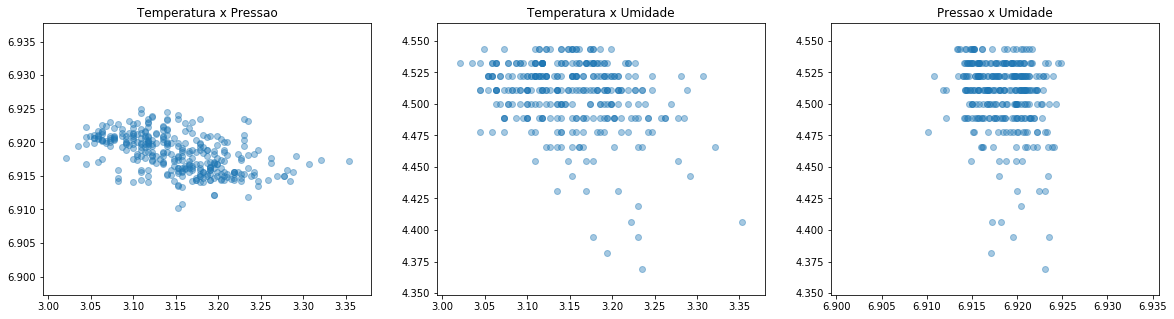

In [81]:
dados_log_com_chuva = dados_log[dados_log['precipitacao']>0]
dados_log_com_chuva.head()
temperatura1_log = dados_log_com_chuva['temp_inst']
pressao1_log = dados_log_com_chuva['pressao']
umidade1_log = dados_log_com_chuva['umid_inst']
precipitacao1_log = dados_log_com_chuva['precipitacao']

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura1_log,pressao1_log, alpha=0.4);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1_log,umidade1_log, alpha=0.4);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1_log,umidade1_log, alpha=0.4);
axs[2].set_title('Pressao x Umidade');

#### Scatter Plots sem Log

Novamente, se trata de uma análise a fim de selecionar variáveis independentes que de fato contribuam com o modelo

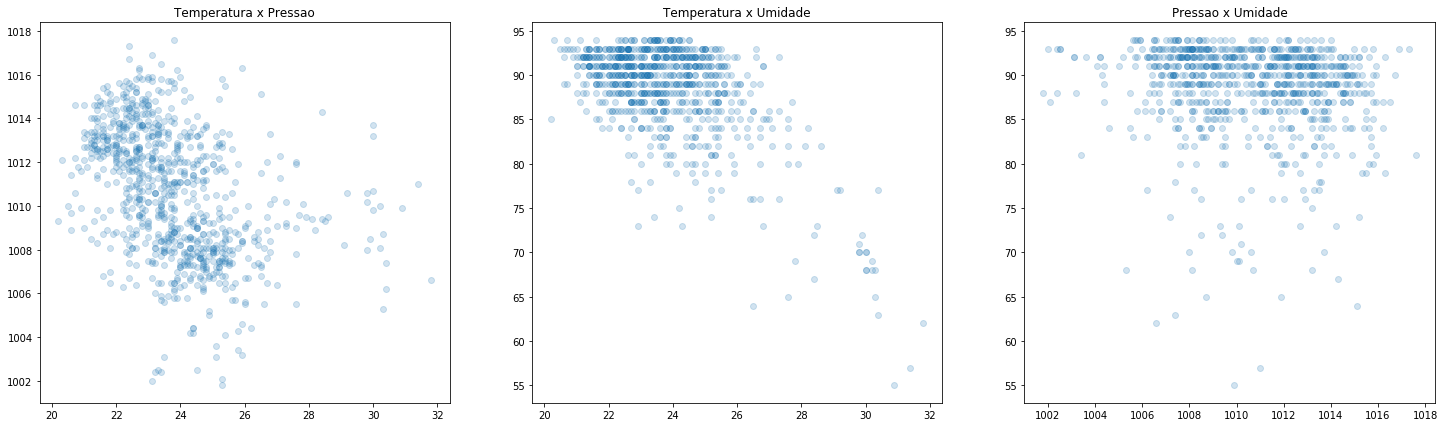

In [83]:
dados_com_chuva = dados5[dados5['precipitacao']>0]

tempo1 = dados_com_chuva['time']
temperatura1 = dados_com_chuva['temp_inst']
pressao1 = dados_com_chuva['pressao']
umidade1 = dados_com_chuva['umid_inst']
precipitacao1 = dados_com_chuva['precipitacao']

temperatura1 = temperatura1.astype(float)
umidade1 = umidade1.astype(float)
pressao1 = pressao1.astype(float)
precipitacao1 = precipitacao1.astype(float)

temperatura1_log = temperatura1_log.astype(float)
umidade1_log = umidade1_log.astype(float)
pressao1_log = pressao1_log.astype(float)
precipitacao1_log = precipitacao1_log.astype(float)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,pressao1, alpha=0.2);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1,umidade1, alpha=0.2);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1,umidade1, alpha=0.2);
axs[2].set_title('Pressao x Umidade');

### Correlação entre as variáveis independentes

Cálculo do valor númerico das correlações entre as variáveis independentes

> Sem uso de log

In [84]:
print('Correlação entre temperatura e pressão:', temperatura1.corr(pressao1))
print('Correlação entre temperatura e umidade:', temperatura1.corr(umidade1))
print('Correlação entre pressão e umidade:',pressao1.corr(umidade1))

Correlação entre temperatura e pressão: -0.4080120542463812
Correlação entre temperatura e umidade: -0.5937465142896663
Correlação entre pressão e umidade: -0.11221407661118415


> Com uso de log

In [85]:
print('Correlação entre temperatura e pressão:', np.log10(temperatura1).corr(pressao1))
print('Correlação entre temperatura e umidade:', np.log10(temperatura1).corr(umidade1))
print('Correlação entre pressão e umidade:',np.log10(pressao1).corr(umidade1))

Correlação entre temperatura e pressão: -0.41917911128224844
Correlação entre temperatura e umidade: -0.5713171064393777
Correlação entre pressão e umidade: -0.11220557875019671


O uso de logaritmos nos valores das variáveis ajuda, em certos casos, a mostrar correlações que antes não eram percebidas dado a sua natureza

 #### Scatter plot das variáveis independentes x dependentes com logaritmo, a fim de visualizar possíveis correlações 

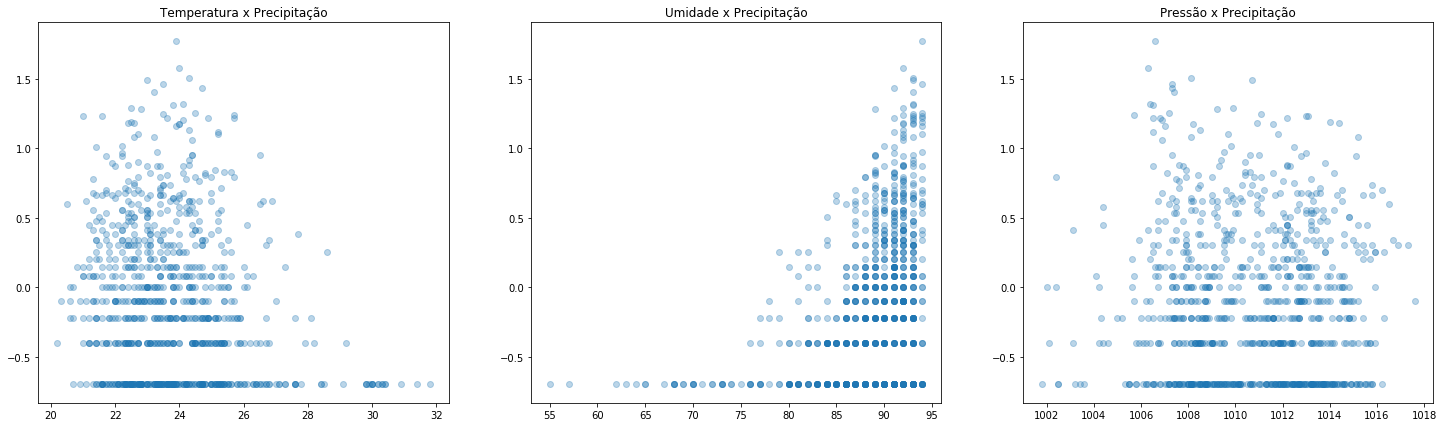

In [86]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,np.log10(precipitacao1), alpha=0.3);
axs[0].set_title('Temperatura x Precipitação');
axs[1].scatter(umidade1,np.log10(precipitacao1), alpha=0.3);
axs[1].set_title('Umidade x Precipitação');
axs[2].scatter(pressao1,np.log10(precipitacao1), alpha=0.3);
axs[2].set_title('Pressão x Precipitação');

## Correlação entre as variáveis independentes e a variável dependente

Este cálculo é crucial para que se perceba quais variáveis podem, de fato contribuir para o modelo. Essa possível contribuição depende da correlação entre as variáveis independentes escolhidas e a variável dependente a ser calculada

> Cálculo sem usar o logaritmo

In [87]:
print('Correlação entre precipitação e pressão:',(precipitacao1).corr(pressao1))
print('Correlação entre precipitação e umidade:',(precipitacao1).corr(umidade1))
print('Correlação entre precipitação e umidade:',(precipitacao1).corr(temperatura1))

Correlação entre precipitação e pressão: -0.10416099945858812
Correlação entre precipitação e umidade: 0.23965562542613641
Correlação entre precipitação e umidade: -0.06115596091605871


> Cálculo usando o logaritmo

In [88]:
print('Correlação entre precipitação e pressão:', np.log10(precipitacao1).corr(pressao1))
print('Correlação entre precipitação e umidade:', np.log10(precipitacao1).corr(umidade1))
print('Correlação entre precipitação e umidade:',np.log10(precipitacao1).corr(temperatura1))

Correlação entre precipitação e pressão: -0.041684956300559704
Correlação entre precipitação e umidade: 0.40611519549190245
Correlação entre precipitação e umidade: -0.194349857609128


## Plot de tabelas OLS

As tabelas OLS são usadas para que se possa ter uma noção de como os dados se comportam e como se dão cetos parâmetros relevântes para a análise

In [217]:
model = sm.OLS(np.log10(precipitacao1),sm.add_constant(umidade1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     57.06
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           1.11e-13
Time:                        15:33:06   Log-Likelihood:                -728.23
No. Observations:                 839   AIC:                             1460.
Df Residuals:                     837   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6851      0.345     -7.789      0.000      -3.362      -2.008
umid_inst      0.0278      0.004      7.554      0.000       0.021       0.035
==============================================================================
Omnibus:                       68.672   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.697
Skew:                           0.552   Prob(JB):                     4.88e-13
Kurtosis:                       2.367   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [218]:
model = sm.OLS(precipitacao1,sm.add_constant(umidade1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     15.18
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           0.000106
Time:                        15:33:07   Log-Likelihood:                -2452.4
No. Observations:                 839   AIC:                             4909.
Df Residuals:                     837   BIC:                             4918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.1628      2.691     -3.033      0.002     -13.445      -2.880
umid_inst      0.1120      0.029      3.896      0.000       0.056       0.168
==============================================================================
Omnibus:                      921.911   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65119.273
Skew:                           5.277   Prob(JB):                         0.00
Kurtosis:                      44.850   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [219]:
model = sm.OLS(precipitacao1,sm.add_constant(temperatura1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.21
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           0.000296
Time:                        15:33:07   Log-Likelihood:                -2453.4
No. Observations:                 839   AIC:                             4911.
Df Residuals:                     837   BIC:                             4920.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2215      0.983     -1.243      0.214      -3.151       0.708
temp_inst      0.1906      0.052      3.634      0.000       0.088       0.294
==============================================================================
Omnibus:                      916.875   Durbin-Watson:                   1.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64599.242
Skew:                           5.226   Prob(JB):                         0.00
Kurtosis:                      44.697   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___
## Analisando os dias que não tiveram chuvas

##### Análise com log

In [143]:
dados_log_sem_chuva = dados_log[dados_log['precipitacao']==0]
dados_log_sem_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao,vento_vel
time,,,,,
2018-11-22 05:00:00,3.169686,6.916517,4.488636,0.0,4.700480
2018-11-26 22:00:00,3.072693,6.916418,4.521789,0.0,4.330733
2018-11-26 23:00:00,3.077312,6.916616,4.521789,0.0,5.170484
2018-11-27 22:00:00,3.025291,6.916616,4.488636,0.0,3.784190
2018-12-02 08:00:00,3.190476,6.911946,4.521789,0.0,3.583519


In [144]:
temperatura2_log = dados_log_com_chuva['temp_inst']
pressao2_log = dados_log_com_chuva['pressao']
umidade2_log = dados_log_com_chuva['umid_inst']
precipitacao2_log = dados_log_com_chuva['precipitacao']

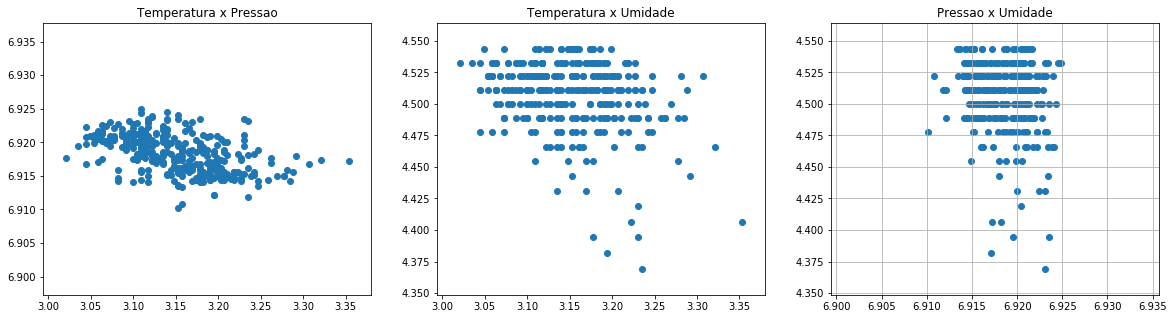

In [147]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2_log,pressao2_log);
axs[0].set_title('Temperatura x Pressao');
plt.grid(True)
axs[1].scatter(temperatura2_log,umidade2_log);
axs[1].set_title('Temperatura x Umidade');
plt.grid(True)
axs[2].scatter(pressao2_log,umidade2_log);
axs[2].set_title('Pressao x Umidade');

##### Análise sem log

In [146]:
dados_sem_chuva = dados5[dados5['precipitacao']==0]
dados_sem_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel
0,2018-11-20 00:00:00,26,1008.9,78,0,72
1,2018-11-20 01:00:00,25.9,1009.4,76,0,62
2,2018-11-20 02:00:00,25.7,1009,77,0,58
3,2018-11-20 03:00:00,25.6,1008.5,79,0,68
4,2018-11-20 04:00:00,25.5,1007.9,79,0,65


In [224]:
tempo2 = dados_sem_chuva['time']
temperatura2 = dados_sem_chuva['temp_inst']
pressao2 = dados_sem_chuva['pressao']
umidade2 = dados_sem_chuva['umid_inst']
precipitacao2 = dados_sem_chuva['precipitacao']

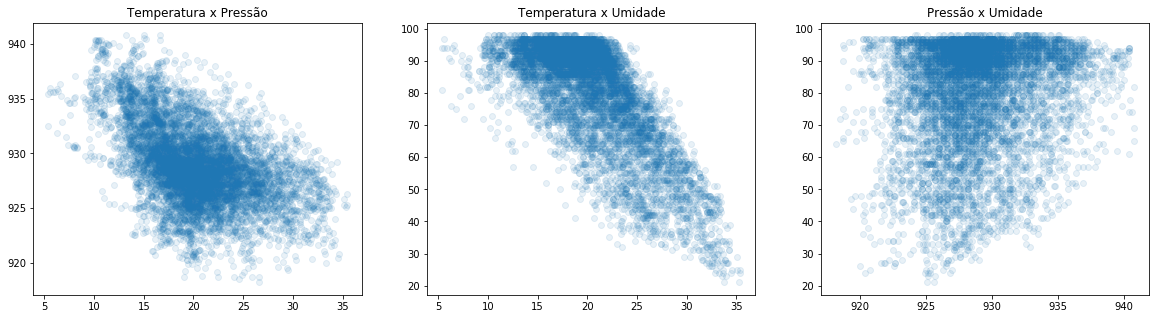

In [225]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2,pressao2, alpha=0.1);
axs[0].set_title('Temperatura x Pressão');
axs[1].scatter(temperatura2,umidade2, alpha=0.1);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2,umidade2, alpha=0.1);
axs[2].set_title('Pressão x Umidade');

***Valores de correlação entre as variáveis***

In [226]:
temperatura2 = temperatura2.astype(float)
umidade2 = umidade2.astype(float)
pressao2 = pressao2.astype(float)
print('Correlação entre temperatura e pressão:', temperatura2.corr(pressao2))
print('Correlação entre temperatura e umidade:', temperatura2.corr(umidade2))
print('Correlação entre pressão e umidade:',pressao2.corr(umidade2))

Correlação entre temperatura e pressão: -0.4953857855829225
Correlação entre temperatura e umidade: -0.7203896264385546
Correlação entre pressão e umidade: 0.1461915872654267


____
# Realizando as regressões

In [89]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [90]:
Y = variacao['precipitacao_t']
X3 = variacao[['temperatura_t', 'pressao_t', 'umidade_t','vento_t']]

In [91]:
results1 = regress(X3.values, Y.values)
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.461
Date:                Tue, 19 Nov 2019   Prob (F-statistic):            0.00900
Time:                        15:10:33   Log-Likelihood:                -692.79
No. Observations:                 247   AIC:                             1396.
Df Residuals:                     242   BIC:                             1413.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.9119     92.479      1.199      0.232     -71.255     293.079
x1             0.6608      0.307      2.154      0.032       0.056       1.265
x2            -0.1086      0.092     -1.185      0.237      -0.289       0.072
x3            -0.0116      0.068     -0.170      0.865      -0.146       0.123
x4            -0.0020      0.004     -0.485      0.628      -0.010       0.006
==============================================================================
Omnibus:                      266.113   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8434.686
Skew:                           4.525   Prob(JB):                         0.00
Kurtosis:                      30.160   Cond. No.                     3.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X3.values, Y.values, test_size=0.2, random_state=0)

In [166]:
results2 = regress(X_test, y_test)
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.686
Date:                Tue, 19 Nov 2019   Prob (F-statistic):              0.170
Time:                        17:09:54   Log-Likelihood:                -124.24
No. Observations:                  50   AIC:                             258.5
Df Residuals:                      45   BIC:                             268.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        402.3081    166.143      2.421      0.020      67.679     736.937
x1             0.1299      0.543      0.239      0.812      -0.965       1.224
x2            -0.3973      0.165     -2.410      0.020      -0.729      -0.065
x3             0.0022      0.123      0.018      0.986      -0.246       0.250
x4             0.0022      0.009      0.253      0.802      -0.015       0.020
==============================================================================
Omnibus:                       76.205   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              991.011
Skew:                           4.017   Prob(JB):                    6.38e-216
Kurtosis:                      23.277   Cond. No.                     3.91e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regressão usando Regressão Linear Múltipla**

In [126]:
#Fazendo a Regrassão Multipla
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

lista_actual2 = list(df2['Actual'])
lista_predicted2 = list(df2['Predicted'])

#Montando um comparador a fim de visualizar a competência do modelo
p = 0
while p < len(df['Predicted']):
    if df['Predicted'][p] < 0:
        df['Predicted'][p] = 0
    
    p += 1
    
lista_actual = list(df['Actual'])
lista_predicted = list(df['Predicted'])

erros = []
k = 0
while k < len(lista_actual):
    erros.append(abs(lista_actual[k] - lista_predicted[k]))
    k += 1
    
print('O erro médio é:',np.mean(erros))
print('O desvio padrão do erro é:', np.std(erros))

O erro médio é: 2.094349382548875
O desvio padrão do erro é: 2.5364878792843255


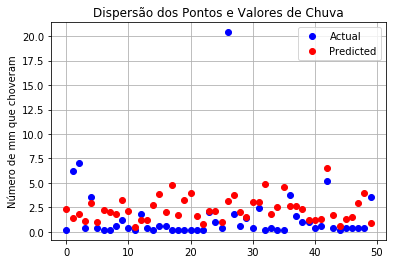

In [137]:
a = np.arange(0,50,1)
plt.plot(a, df['Actual'], 'bo')
plt.plot(a, df['Predicted'], 'ro')
plt.title('Dispersão dos Pontos e Valores de Chuva')
plt.ylabel("Número de mm que choveram")
plt.grid(True)
plt.legend()
plt.show()

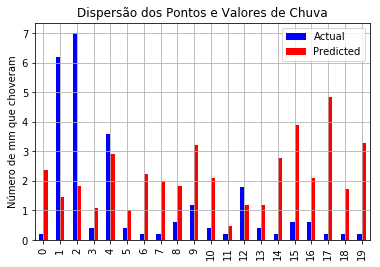

In [138]:
df.iloc[:20,:].plot(kind='bar', color=('blue', 'red'), legend=True );
plt.title('Dispersão dos Pontos e Valores de Chuva')
plt.ylabel("Número de mm que choveram")
plt.grid(True)

**Regressão usando Random Forrest Regressor**

In [139]:
from sklearn.ensemble import RandomForestRegressor

# Setando 100 árvores de decisão
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Treinando o modelo
rf.fit(X_train, y_train);

# Fazendo as predições
predictions = rf.predict(X_test)

#Criando DataSet da comparação
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

#Montando comparador
p = 0
while p < len(df2['Predicted']):
    if df2['Predicted'][p] < 0:
        df2['Predicted'][p] = 0
    
    p += 1
    
lista_actual2 = list(df2['Actual'])
lista_predicted2 = list(df2['Predicted'])

erros2 = []
k = 0
while k < len(lista_actual2):
    erros2.append(abs(lista_actual2[k] - lista_predicted2[k]))
    k += 1
    
print('O erro médio é:',np.mean(erros2))
print('O desvio padrão do erro é:', np.std(erros2))

O erro médio é: 2.799080000000001
O desvio padrão do erro é: 3.6779048429234846


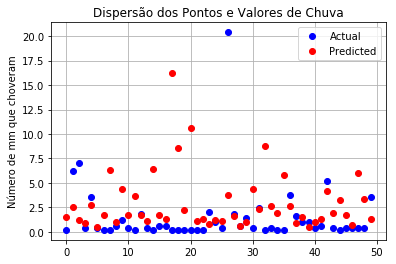

In [140]:
plt.plot(a, df2['Actual'], 'bo')
plt.plot(a, df2['Predicted'], 'ro')
plt.title('Dispersão dos Pontos e Valores de Chuva')
plt.ylabel("Número de mm que choveram")
plt.grid(True)
plt.legend()
plt.show()

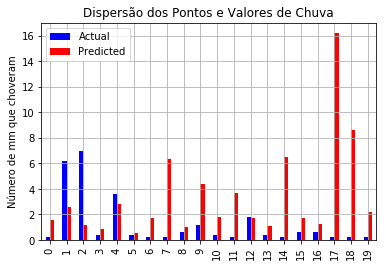

In [141]:
df2.iloc[:20,:].plot(kind='bar', color=('blue', 'red'), legend=True );
plt.title('Dispersão dos Pontos e Valores de Chuva')
plt.ylabel("Número de mm que choveram")
plt.grid(True)

# Conclusões

O objetivo principal do projeto é de usar dados de tempos anteriores para prever a quantidade de chuva que cairá no futuro. Para isso, um modelo de regressão linear múltipla foi escolhido para ser usado. Porém, antes que fizessemos qualquer tipo de previsão, foi necessário que se "limpasse" os dados, filtrando e manipulando-os de forma a fazê-los, de maneira honesta, se comportarem em um modo mais adequado para o uso na regressão.

Foi nesta fase de manipulação dos dados em que se encontrou indícios de problemas que viram a comprometer o modelo preditivo. As correlações entre as variáveis independentes escolhidas, Temperatura, Pressão e Umidade, e a variável dependente, de precipitação, se mostraram muito baixas. Esse fato implica na  dificuldade de se prever este fenômeno, dado que os dados tido como mais valiosos, empiricamente, apresentaram correlações muito baixas, ou seja, não descrevem com qualidade o comportamento da variável a ser analisada.

Isso tudo resultou em previsões de baixíssima precisão por parte do modelo de regrassão múltipla que, na prática, não valeriam de nada. Com valores de R quadrado em torno de 0.054, as previsões passarm longe dos valores reais.

Tentativas foram feitas para que se aumentasse a correlação entre os dados e a precipitação, porém, sem sucesso. Depois de tudo isso, teve-se como hipótese que o DataSet se mostrava anormal, talvez por medições de má qualidade ou, mais provavelmente, por um comportamento mais extremo dos dados, em que são muito escassos os dias de chuva, o que compromete a previsão. 

Tendo tudo isto em vista, entende-se como razoável a troca de DataSet por um que tenha um comportamento mais balanceado na questão de chuva e seca. E assim foi feito nas análises que se encontram em outros Notebooks.

# Referências

>

>